In [2]:
from datetime import datetime
import numpy as np
import sys
import os
import torch 
import torch.nn as nn
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
class Softmax:
    def predict(self, x):
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores)

    def loss(self, x, y):
        probs = self.predict(x)
        return -np.log(probs[y])

    def diff(self, x, y):
        probs = self.predict(x)
        probs[y] -= 1.0
        return probs

    def forward(self, x, tau = 1.0):
        e = np.exp( np.array(x) / tau )
        return e / np.sum( e )


In [4]:
class Sigmoid:
    def forward(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def backward(self, x, top_diff):
        output = self.forward(x)
        return (1.0 - output) * output * top_diff

class Tanh:
    def forward(self, x):
        return np.tanh(x)

    def backward(self, x, top_diff):
        output = self.forward(x)
        return (1.0 - np.square(output)) * top_diff

In [5]:
class MultiplyGate:
    def forward(self,W, x):
        return np.dot(W, x)

    def backward(self, W, x, dz):
        dW = np.asarray(np.dot(np.transpose(np.asmatrix(dz)), np.asmatrix(x)))
        dx = np.dot(np.transpose(W), dz)
        return dW, dx

class AddGate:
    def forward(self, x1, x2):
        return x1 + x2

    def backward(self, x1, x2, dz):
        dx1 = dz * np.ones_like(x1)
        dx2 = dz * np.ones_like(x2)
        return dx1, dx2

In [6]:
class RNNLayer:
    
    def __init__(self):
        self.mulGate = MultiplyGate()
        self.addGate = AddGate()
        self.activation = Tanh()

    def forward(self, x, prev_s, U, W, V):
        self.mulu = self.mulGate.forward(U, x)
        self.mulw = self.mulGate.forward(W, prev_s)
        self.add = self.addGate.forward(self.mulw, self.mulu)
        self.s = self.activation.forward(self.add)
        self.mulv = self.mulGate.forward(V, self.s)

    def backward(self, x, prev_s, U, W, V, diff_s, dmulv):
        self.forward(x, prev_s, U, W, V)
        dV, dsv = self.mulGate.backward(V, self.s, dmulv)
        ds = dsv + diff_s
        dadd = self.activation.backward(self.add, ds)
        dmulw, dmulu = self.addGate.backward(self.mulw, self.mulu, dadd)
        dW, dprev_s = self.mulGate.backward(W, prev_s, dmulw)
        dU, dx = self.mulGate.backward(U, x, dmulu)
        return (dprev_s, dU, dW, dV)

In [7]:
class RNN_BPTT:
    def __init__(self, word_dim, hidden_dim=100, bp_truncate=4):
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bp_truncate = bp_truncate
        self.U = np.random.uniform(-np.sqrt(1. / word_dim), np.sqrt(1. / word_dim), (hidden_dim, word_dim))
        self.W = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), (hidden_dim, hidden_dim))
        self.V = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), (word_dim, hidden_dim))
        self.grad_arr = []
        self.grad_arr_norm = []
        
    def forward_propagation(self, x):
        # The total number of time steps
        T = len(x)
        layers = []
        prev_s = np.zeros(self.hidden_dim)
        # For each time step...
        for t in range(T):
            layer = RNNLayer()
            input = np.zeros(self.word_dim)
            input[x[t]] = 1
            layer.forward(input, prev_s, self.U, self.W, self.V)
            prev_s = layer.s
            layers.append(layer)
        return layers

    def predict(self, x):
        output = Softmax()
        layers = self.forward_propagation(x)
        return [np.argmax(output.predict(layer.mulv)) for layer in layers]

    def calculate_loss(self, x, y):
        assert len(x) == len(y)
        output = Softmax()
        layers = self.forward_propagation(x)
        loss = 0.0
        for i, layer in enumerate(layers):
            loss += output.loss(layer.mulv, y[i])
        return loss / float(len(y))

    def calculate_total_loss(self, X, Y):
        loss = 0.0
        for i in range(len(Y)):
            loss += self.calculate_loss(X[i], Y[i])
        return loss / float(len(Y))

    def bptt(self, x, y):
        assert len(x) == len(y)
        output = Softmax()
        layers = self.forward_propagation(x)
        dU = np.zeros(self.U.shape)
        dV = np.zeros(self.V.shape)
        dW = np.zeros(self.W.shape)

        T = len(layers)
        prev_s_t = np.zeros(self.hidden_dim)
        diff_s = np.zeros(self.hidden_dim)
        for t in range(0, T):
            dmulv = output.diff(layers[t].mulv, y[t])
            input = np.zeros(self.word_dim)
            input[x[t]] = 1
            dprev_s, dU_t, dW_t, dV_t = layers[t].backward(input, prev_s_t, self.U, self.W, self.V, diff_s, dmulv)
            prev_s_t = layers[t].s
            dmulv = np.zeros(self.word_dim)
            for i in range(t-1, max(-1, t-self.bp_truncate-1), -1):
                input = np.zeros(self.word_dim)
                input[x[i]] = 1
                prev_s_i = np.zeros(self.hidden_dim) if i == 0 else layers[i-1].s
                dprev_s, dU_i, dW_i, dV_i = layers[i].backward(input, prev_s_i, self.U, self.W, self.V, dprev_s, dmulv)
                dU_t += dU_i
                dW_t += dW_i
            dV += dV_t
            dU += dU_t
            dW += dW_t
       
        return (dU, dW, dV)

    def sgd_step(self, x, y, learning_rate):
        dU, dW, dV = self.bptt(x, y)
        self.U -= learning_rate * dU
        self.V -= learning_rate * dV
        self.W -= learning_rate * dW
        return dU, dW, dV
    
    def train(self, rep_tensor,learning_rate=0.005, nepoch=100, evaluate_loss_after=5,num_steps=20):
        num_examples_seen = 0
        losses = []
        grad_step = 0
        initialized = False
        for epoch in range(nepoch):
            X = rep_tensor[:, epoch*num_steps:(epoch+1)*num_steps]
            Y = rep_tensor[:, epoch*num_steps+1:(epoch+1)*num_steps+1]
            if (epoch % evaluate_loss_after == 0):
                loss = self.calculate_total_loss(X, Y)
                losses.append((num_examples_seen, loss))
                time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                print("%s: Loss after num_examples_seen=%d epoch=%d: %f" % (time, num_examples_seen, epoch, loss))
                if (initialized):
                    tdLdU = LA.norm([x / num_examples_seen for x in tdLdU])
                    tdLdV = LA.norm([x / num_examples_seen for x in tdLdV])
                    tdLdW = LA.norm([x / num_examples_seen for x in tdLdW])
                    #grad_step= LA.norm([tdLdU,tdLdW,tdLdV])
                    #self.grad_arr_norm.append(grad_step)
                    self.grad_arr.append([tdLdU,tdLdW,tdLdV])
                    print("Average gradient dL/dU,dL/dW,dL/dV: " , [tdLdU,tdLdW,tdLdV])
                   # print("Gradient norm applied: " ,grad_step)
                # Adjust the learning rate if loss increases
                if len(losses) > 1 and losses[-1][1] > losses[-2][1]:
                    learning_rate = learning_rate * 0.5
                    print("Setting learning rate to %f" % learning_rate)
                sys.stdout.flush()
            # For each training example...
            for i in range(len(Y)):
                dU, dW, dV = self.sgd_step(X[i], Y[i], learning_rate)
                num_examples_seen += 1
                if initialized == False:
                    tdLdU = np.zeros_like(dU)
                    tdLdV = np.zeros_like(dV)
                    tdLdW = np.zeros_like(dW)
                    initialized = True
                tdLdU += dU 
                tdLdV += dV
                tdLdW += dW
        return losses    

In [8]:
class Gru_BPTT:

    def __init__(self, word_dim, hidden_dim = 30, bptt_truncate = 2 ):
        #Assign instance variables
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        self.sigmoid = Sigmoid()
        self.softmax = Softmax()
        self.grad_arr = []
        # Random asisgn weight 
        self.U = np.random.uniform( -np.sqrt(1./word_dim), np.sqrt(1./word_dim), (3, hidden_dim, word_dim) )
        self.W = np.random.uniform( -np.sqrt(1./word_dim), np.sqrt(1./word_dim), (3, hidden_dim, hidden_dim) )
        self.V = np.random.uniform( -np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (word_dim, hidden_dim) )
        self.b = np.zeros( (3, hidden_dim) )
        self.c = np.zeros( word_dim )
        pass

    def forward_propagation(self, x):
        # The total number of time steps
        T = len(x)
        z = np.zeros((T + 1, self.hidden_dim))
        r = np.zeros((T + 1, self.hidden_dim))
        h = np.zeros((T + 1, self.hidden_dim))
        s = np.zeros((T + 1, self.hidden_dim))
        o= np.zeros((T, self.word_dim))

        for t in range(T):
            z[t]=self.sigmoid.forward(self.U[0,:,x[t]] + self.W[0].dot(s[t-1]) + self.b[2])
            r[t]=self.sigmoid.forward(self.U[1,:,x[t]] + self.W[1].dot(s[t-1]) + self.b[1])
            h[t]=np.tanh( self.U[2,:,x[t]] + self.W[2].dot(s[t-1]*r[t]) + self.b[0])
            s[t]=(1-z[t])*h[t]+z[t]*s[t-1]
            o[t]=self.softmax.forward( self.V.dot(h[t]) + self.c)
        return [z, r, h, s, o]

    def predict( self, x): 
        z, r, h, s, o= self.forward_propagation( x )
        return np.argmax(o , axis = 1)
    
    
    def calculate_loss( self, x, y):
        L=0.0
        # For each sentences
        N = np.sum( ( len(y_i) for y_i in y) )
        for i in range( len(y) ):
            z, r, h, s, o = self.forward_propagation( x[i] )
            correct_word_predictions = o[np.arange(len(y[i])), y[i]]
            L += -1* np.sum(np.log(correct_word_predictions))
        return L / float(len(y))

    def bptt(self, x, y):
        T = len(y)
        # Perform forward propagation
        z, r, h, s, o = self.forward_propagation(x)

        # Then we need to calculate the gradients
        dLdU = np.zeros(self.U.shape)
        dLdV = np.zeros(self.V.shape)
        dLdW = np.zeros(self.W.shape)
        dLdb = np.zeros(self.b.shape)
        dLdc = np.zeros(self.c.shape)

        delta_o = o
        delta_o[ np.arange(len(y)), y ] -= 1.0

        for t in np.arange(T)[::-1]:
            dLdV += np.outer( delta_o[t], s[t].T )
            delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
            dLdc += delta_o[t]
            for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:

                dLdW[0] += np.outer(delta_t, s[bptt_step-1])
                dLdU[0,:,x[bptt_step]] += delta_t
                dLdb[0] += delta_t

                dLdr = self.W[0].T.dot(delta_t) * (s[bptt_step-1])
                dLdW[1] += np.outer( dLdr*r[bptt_step]*(1-r[bptt_step]), s[bptt_step-1] )
                dLdU[1,:,x[bptt_step]] += dLdr*r[bptt_step]*(1-r[bptt_step])
                dLdb[1] += dLdr * r[bptt_step] * (1-r[bptt_step])

                if bptt_step>=1:
                    dLdz = self.W[0].T.dot(delta_t) * r[bptt_step] * (s[bptt_step-2]-h[bptt_step])
                    dLdW[2] += np.outer( dLdz * z[bptt_step] * (1-z[bptt_step]), s[bptt_step-1] )
                    dLdU[2,:,x[bptt_step] ] += dLdz * z[bptt_step] * (1-z[bptt_step])
                    dLdb[2] += dLdz * z[bptt_step] * (1-z[bptt_step])

        return [ dLdU, dLdV, dLdW, dLdb, dLdc ]

    def sgd_step(self, x, y, learning_rate):
        dLdU, dLdV, dLdW, dLdb, dLdc = self.bptt(x, y)
        self.U -= learning_rate * dLdU
        self.V -= learning_rate * dLdV
        self.W -= learning_rate * dLdW
        self.b -= learning_rate * dLdb
        self.c -= learning_rate * dLdc
        return dLdU, dLdV, dLdW, dLdb, dLdc

    def arr_sum(self, a, b):
        arr = []
        for i in range(len(a)):
            arr.append(a[i] + b[i])
        return arr
    
    def train(self,rep_tensor , learning_rate=0.003, nepoch=200, evaluate_loss_after=5, num_steps=20):
        losses = []
        vector_total = [0,0,0,0,0]
        initialized = False
        num_examples_seen = 0       
        test=0
        grad_step = 0
        for epoch in range( nepoch ):
            X = rep_tensor[:, epoch*num_steps:(epoch+1)*num_steps]
            Y = rep_tensor[:, epoch*num_steps+1:(epoch+1)*num_steps+1]
            if (epoch % evaluate_loss_after == 0):
                loss = self.calculate_loss(X,Y)
                losses.append((num_examples_seen, loss ))
                time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                print("%s: Loss after num_examples_seen=%d epoch=%d: %f" % (time, num_examples_seen, epoch, loss))
                if (initialized):
                    print("test",test)
                    test=0
                    tdLdU = LA.norm([x / num_examples_seen for x in tdLdU])
                    tdLdV = LA.norm([x / num_examples_seen for x in tdLdV])
                    tdLdW = LA.norm([x / num_examples_seen for x in tdLdW])
                    tdLdb = LA.norm([x / num_examples_seen for x in tdLdb])
                    tdLdc = LA.norm([x / num_examples_seen for x in tdLdc])                 
                    #grad_step = LA.norm([tdLdU, tdLdV, tdLdW, tdLdb, tdLdc])
                    #self.grad_arr_norm.append(grad_step)
                    self.grad_arr.append([tdLdU, tdLdV, tdLdW, tdLdb, tdLdc])
                    print("Average gradient normalized dL/dU, dL/dV, dL/dW, dL/db, dL/dc:" ,[tdLdU, tdLdV, tdLdW, tdLdb, tdLdc])
                    #print("Gradient normalized:" ,grad_step)
                sys.stdout.flush()
            # For each training example...
            for i in range(len(Y)):
                dLdU, dLdV, dLdW, dLdb, dLdc = self.sgd_step(X[i], Y[i], learning_rate)
                if initialized == False:
                    tdLdU = np.zeros_like(dLdU)
                    tdLdV = np.zeros_like(dLdV)
                    tdLdW = np.zeros_like(dLdW)
                    tdLdb = np.zeros_like(dLdb)
                    tdLdc = np.zeros_like(dLdc)
                    initialized = True
                tdLdU += dLdU 
                tdLdV += dLdV
                tdLdW += dLdW
                tdLdb += dLdb
                tdLdc += dLdc
                num_examples_seen += 1
                test += 1
        return losses 

In [9]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
            
    def __len__(self):
        return len(self.word2idx)

In [10]:
class TextProcess(object):
    
    def __init__(self):
        self.dictionary = Dictionary()

    def get_data(self, path, batch_size=20):
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words: 
                    self.dictionary.add_word(word)  
        #Create a 1-D tensor that contains the index of all the words in the file
        rep_tensor = torch.LongTensor(tokens)
        index = 0
        with open(path, 'r') as f:
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    rep_tensor[index] = self.dictionary.word2idx[word]
                    index += 1
        #Find out how many batches we need   
        num_batches = rep_tensor.shape[0] // batch_size   
        print("# Batches: ", num_batches)
        print("Batch size: ", batch_size)
        #Remove the remainder (Filter out the ones that don't fit)
        rep_tensor = rep_tensor[:num_batches*batch_size]
        print("vocab_size: ", len(self.dictionary.idx2word))
        rep_tensor = rep_tensor.view(batch_size, -1)
        print("Rep_tensor shape: ", rep_tensor.shape)
        return rep_tensor

In [21]:
BATCH_SIZE = 100 
doc = TextProcess()
rep_tensor = doc.get_data('data/ptb.char.train.txt', 1)

# Batches:  5017483
Batch size:  1
vocab_size:  50
Rep_tensor shape:  torch.Size([1, 5017483])


In [51]:
num_steps = 20
epoch_size = 35
lr = 0.005
evaluate_loss_after=1

In [52]:
word_dim = 10000
hidden_dim = 100
np.random.seed(10)
rnn = RNN_BPTT(word_dim, hidden_dim)
# rnn.sgd_step(x[10], y[10], 0.005)

In [53]:
losses_rnn = rnn.train(rep_tensor, learning_rate=lr, nepoch=epoch_size, evaluate_loss_after=evaluate_loss_after, num_steps=num_steps)

2019-03-25 14:28:05: Loss after num_examples_seen=0 epoch=0: 9.211880
2019-03-25 14:28:08: Loss after num_examples_seen=1 epoch=1: 9.209717
Average gradient dL/dU,dL/dW,dL/dV:  [3.545807358785876, 0.23961817135351107, 0.34526644738227136]
2019-03-25 14:28:10: Loss after num_examples_seen=2 epoch=2: 9.210492
Average gradient dL/dU,dL/dW,dL/dV:  [1772.9017802031858, 11.981109745885034, 172.63331138300182]
Setting learning rate to 0.002500
2019-03-25 14:28:12: Loss after num_examples_seen=3 epoch=3: 9.210090
Average gradient dL/dU,dL/dW,dL/dV:  [590967.2571843353, 399.37007083008785, 57544.43712776287]
2019-03-25 14:28:15: Loss after num_examples_seen=4 epoch=4: 9.209266
Average gradient dL/dU,dL/dW,dL/dV:  [147741814.29387936, 9984.251351929806, 14386109.281940162]
2019-03-25 14:28:17: Loss after num_examples_seen=5 epoch=5: 9.210165
Average gradient dL/dU,dL/dW,dL/dV:  [29548362858.75479, 199685.0266695234, 2877221856.3883467]
Setting learning rate to 0.001250
2019-03-25 14:28:19: Loss 

In [54]:
print(losses_rnn)

[(0, 9.211879802968495), (1, 9.209716527872258), (2, 9.210491865761197), (3, 9.21009024983367), (4, 9.209266121580386), (5, 9.210164803515474), (6, 9.208942773032263), (7, 9.21083483378589), (8, 9.208104718060676), (9, 9.209952678794009), (10, 9.210293954811018), (11, 9.209719286823084), (12, 9.21050064659886), (13, 9.210005408806973), (14, 9.20983167726049), (15, 9.209565434230822), (16, 9.208815656201766), (17, 9.209409770669277), (18, 9.208723822642622), (19, 9.209816116693414), (20, 9.209622595984511), (21, 9.210985349902378), (22, 9.208339520104413), (23, 9.2100787755842), (24, 9.209178466934414), (25, 9.209174436087391), (26, 9.208488143810708), (27, 9.209069420989536), (28, 9.208788023049916), (29, 9.21022478856743), (30, 9.209930047193435), (31, 9.207451826224432), (32, 9.208444385099634), (33, 9.20717588271176), (34, 9.21072499109475)]


In [55]:
rnn_grad_arr=[]
for i in range(len(rnn.grad_arr)):
    rnn_grad_arr.append(rnn.grad_arr[i][1])

rnn_grad_zero = rnn_grad_arr/max(rnn_grad_arr)

In [56]:
word_dim = 10000
hidden_dim = 100
gru = Gru_BPTT(hidden_dim)
losses_gru = gru.train(rep_tensor,learning_rate=lr, nepoch=epoch_size, evaluate_loss_after=evaluate_loss_after)
#z, r, h, s, o = gru.forward_propagation( X_train[0] )
#predictions = rnn.predict( X_train[0] )

2019-03-25 14:29:26: Loss after num_examples_seen=0 epoch=0: 92.042945
2019-03-25 14:29:26: Loss after num_examples_seen=1 epoch=1: 91.985057
test 1
Average gradient normalized dL/dU, dL/dV, dL/dW, dL/db, dL/dc: [5.246273908666094, 0.9178494968052929, 1.2911205634352994, 11.666915279143012, 6.004086053079354]
2019-03-25 14:29:26: Loss after num_examples_seen=2 epoch=2: 91.612393
test 1
Average gradient normalized dL/dU, dL/dV, dL/dW, dL/db, dL/dc: [248.9345376074864, 25.14044005004945, 33.54538957594336, 56.292108905119264, 30.161340068556296]
2019-03-25 14:29:27: Loss after num_examples_seen=3 epoch=3: 91.295408
test 1
Average gradient normalized dL/dU, dL/dV, dL/dW, dL/db, dL/dc: [7872.0200331982, 458.9996308881552, 581.0277585625732, 178.23645974414868, 100.55760408009318]
2019-03-25 14:29:27: Loss after num_examples_seen=4 epoch=4: 90.982287
test 1
Average gradient normalized dL/dU, dL/dV, dL/dW, dL/db, dL/dc: [186701.34752353403, 6285.1112980276, 7547.771479461476, 422.72408423257

In [57]:
print(losses_gru)

[(0, 92.04294511664378), (1, 91.98505678808324), (2, 91.61239336138613), (3, 91.29540764035181), (4, 90.98228695104237), (5, 91.11983978937651), (6, 90.61566189591724), (7, 90.94503283177077), (8, 90.78538207561705), (9, 90.33284597370611), (10, 89.8074700148318), (11, 89.49093268416095), (12, 89.67124918457866), (13, 89.14971074025995), (14, 89.29222898569333), (15, 90.2896597993608), (16, 88.80152457551193), (17, 88.41506380290934), (18, 87.70112777632603), (19, 87.8639353539991), (20, 87.19475640623389), (21, 86.72353762075588), (22, 87.53766812968568), (23, 86.03014294578074), (24, 84.82016035099721), (25, 84.86767260434202), (26, 85.22245482893335), (27, 84.04066612193338), (28, 83.3375778219327), (29, 82.9831235471972), (30, 82.41548625501218), (31, 80.78308242605351), (32, 82.93239670100502), (33, 84.86566145411393), (34, 83.43724322115304)]


In [58]:
num_examples = []
gru_losses = []
for i in range(len(losses_gru)):
    num_examples.append(losses_gru[i][0])
    gru_losses.append(losses_gru[i][1])

In [59]:
rnn_losses = []
for i in range(len(losses_rnn)):
    num_examples.append(losses_rnn[i][0])
    rnn_losses.append(losses_rnn[i][1])

In [60]:
print(gru.grad_arr)

[[5.246273908666094, 0.9178494968052929, 1.2911205634352994, 11.666915279143012, 6.004086053079354], [248.9345376074864, 25.14044005004945, 33.54538957594336, 56.292108905119264, 30.161340068556296], [7872.0200331982, 458.9996308881552, 581.0277585625732, 178.23645974414868, 100.55760408009318], [186701.34752353403, 6285.1112980276, 7547.771479461476, 422.7240842325778, 251.39721420379843], [3542409.017446881, 68849.94468769923, 78438.74663124591, 802.216471130983, 502.7960854744179], [56010404.52450727, 628511.1298073046, 679299.4607330379, 1268.7092919092313, 837.9939988125356], [759087647.0072072, 4917853.191978837, 5042490.761028776, 1719.5841888806735, 1197.1345856378693], [9001672155.90124, 33670239.096819915, 32751938.235922083, 2039.163439399366, 1496.4184173559427], [94885955875.8943, 204910549.66578487, 189093403.56679857, 2149.539559585753, 1662.6872545528067], [900167215590.2031, 1122341303.2273304, 982558147.0526432, 2039.4017972638537, 1662.6873601349246], [7763396389845.

In [61]:
gru_grad_arr=[]
for i in range(len(gru.grad_arr)):
    gru_grad_arr.append(gru.grad_arr[i][4])

gru_grad_zero = gru_grad_arr/max(gru_grad_arr)

In [62]:
print(num_examples)
print(gru_losses)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[92.04294511664378, 91.98505678808324, 91.61239336138613, 91.29540764035181, 90.98228695104237, 91.11983978937651, 90.61566189591724, 90.94503283177077, 90.78538207561705, 90.33284597370611, 89.8074700148318, 89.49093268416095, 89.67124918457866, 89.14971074025995, 89.29222898569333, 90.2896597993608, 88.80152457551193, 88.41506380290934, 87.70112777632603, 87.8639353539991, 87.19475640623389, 86.72353762075588, 87.53766812968568, 86.03014294578074, 84.82016035099721, 84.86767260434202, 85.22245482893335, 84.04066612193338, 83.3375778219327, 82.9831235471972, 82.41548625501218, 80.78308242605351, 82.93239670100502, 84.86566145411393, 83.43724322115304]


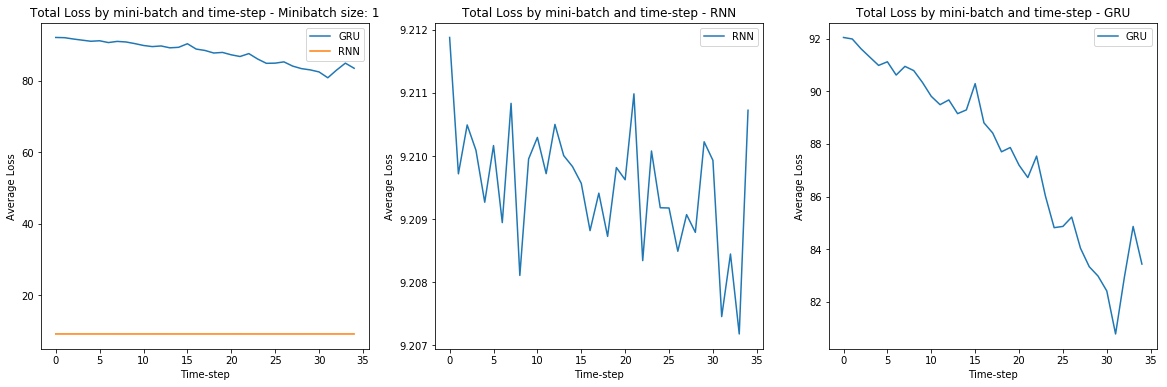

In [65]:
epoch_arr=[range(35)]
fig, ax = plt.subplots(1,3,figsize=(20, 6))
ax[0].plot(epoch_arr[0],gru_losses, label='GRU')
ax[0].plot(epoch_arr[0],rnn_losses, label='RNN')
ax[0].legend()
ax[1].plot(epoch_arr[0],rnn_losses, label='RNN')
ax[1].legend()
ax[2].plot(epoch_arr[0],gru_losses, label='GRU')
ax[2].legend()
ax[0].set_xlabel('Time-step')
ax[0].set_ylabel('Average Loss')
ax[0].set_title('Total Loss by mini-batch and time-step - Minibatch size: 1' )
ax[1].set_xlabel('Time-step')
ax[1].set_ylabel('Average Loss')
ax[1].set_title('Total Loss by mini-batch and time-step - RNN')
ax[2].set_xlabel('Time-step')
ax[2].set_ylabel('Average Loss')
ax[2].set_title('Total Loss by mini-batch and time-step - GRU')
plt.show()

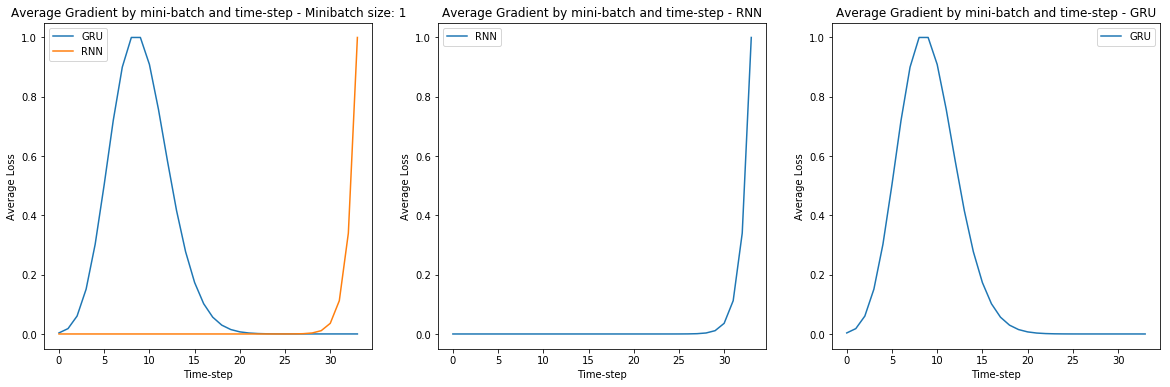

In [67]:
epoch_arr=[range(34),range(34)]
fig, ax = plt.subplots(1,3,figsize=(20, 6))
ax[0].plot(epoch_arr[1],gru_grad_zero, label='GRU')
ax[0].plot(epoch_arr[0],rnn_grad_zero, label='RNN')
ax[0].legend()
ax[2].plot(epoch_arr[0],gru_grad_zero, label='GRU')
ax[2].legend()
ax[1].plot(epoch_arr[1],rnn_grad_zero, label='RNN')
ax[1].legend()
ax[0].set_xlabel('Time-step')
ax[0].set_ylabel('Average Loss')
ax[0].set_title('Average Gradient by mini-batch and time-step - Minibatch size: 1' )
ax[1].set_xlabel('Time-step')
ax[1].set_ylabel('Average Loss')
ax[1].set_title('Average Gradient by mini-batch and time-step - RNN')
ax[2].set_xlabel('Time-step')
ax[2].set_ylabel('Average Loss')
ax[2].set_title('Average Gradient by mini-batch and time-step - GRU')
plt.show()